This notebook demonstrates an unsupervised clustering approach for the Fashion MNIST dataset. We will use a pre-trained VGG16 model to extract features from the images and then apply the K-Means algorithm to group similar images. Finally, we'll evaluate the clusters using various metrics and visualizations.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE

In [8]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Combine training and testing data for clustering
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Normalize and reshape the images for the CNN
x_all = x_all.astype('float32') / 255.0
x_all = np.stack([x_all]*3, axis=-1)  # VGG16 expects 3 channels

Shape of combined dataset: (70000, 28, 28, 3)
Shape of combined labels: (70000,)


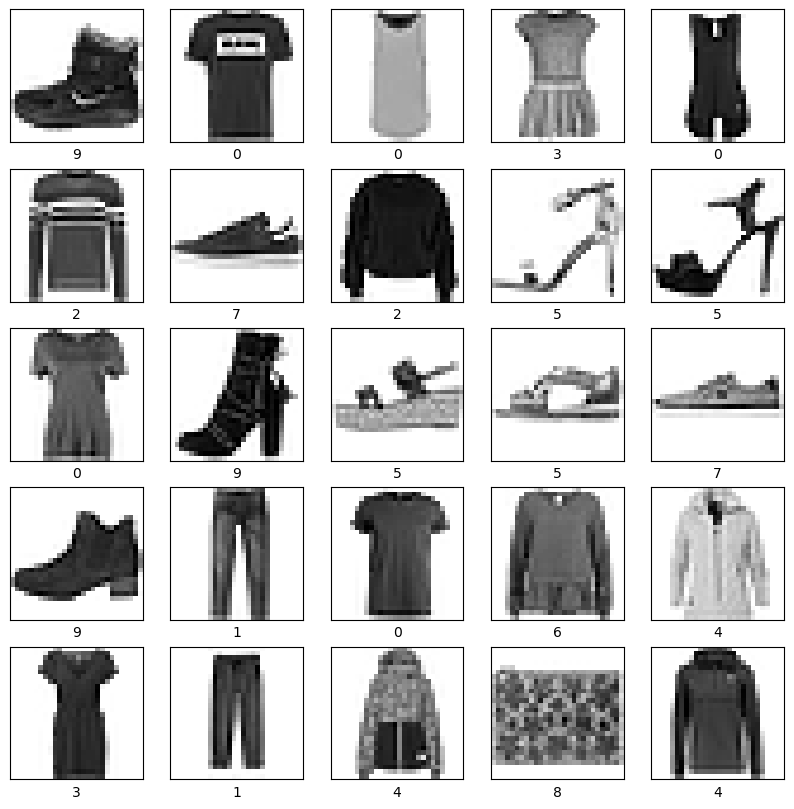

In [9]:
print(f'Shape of combined dataset: {x_all.shape}')
print(f'Shape of combined labels: {y_all.shape}')

# Display 25 sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # VGG16 expects 3 channels, so we can display one of them
    plt.imshow(x_all[i, :, :, 0], cmap=plt.cm.binary)
    plt.xlabel(y_all[i])
plt.show()

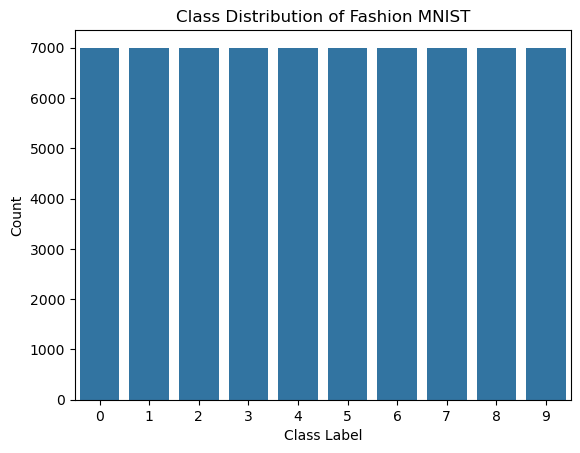

In [10]:
# Check class distribution
sns.countplot(x=y_all)
plt.title('Class Distribution of Fashion MNIST')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [11]:
# Load the VGG16 model without the top classification layer
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Because Fashion MNIST images are 28x28, we need to resize them to 32x32 for VGG16
from tensorflow.image import resize
x_all_resized = resize(x_all, [32, 32])

# Create a new model that outputs the features from the last pooling layer
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block3_pool').output)

# Extract features from the resized images
features = feature_extractor.predict(x_all_resized)

# Flatten the features for K-Means clustering
features_flat = features.reshape(features.shape[0], -1)

print(f'Shape of extracted features: {features_flat.shape}')

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 277s 126ms/step
Shape of extracted features: (70000, 4096)


In [13]:
pca = PCA(n_components=100)
x_pca = pca.fit_transform(features_flat)

In [14]:
# Initialize and fit the K-Means model
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(x_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

In [15]:
# Calculate Silhouette Score
silhouette = silhouette_score(x_pca, cluster_labels)
print(f'Silhouette Score: {silhouette:.4f}')

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_all, cluster_labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')

Silhouette Score: 0.1738
Adjusted Rand Index (ARI): 0.4632


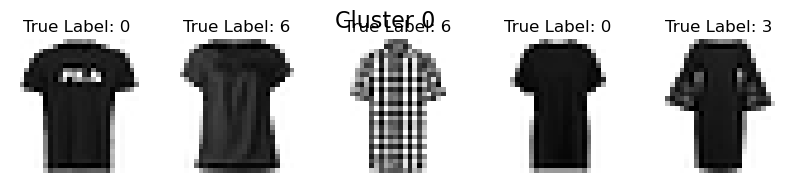

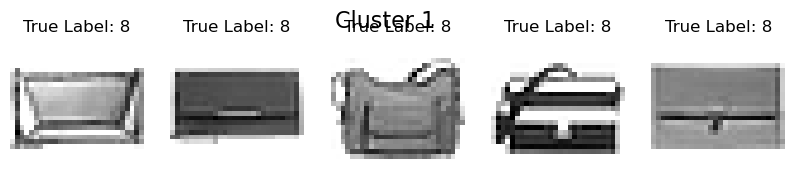

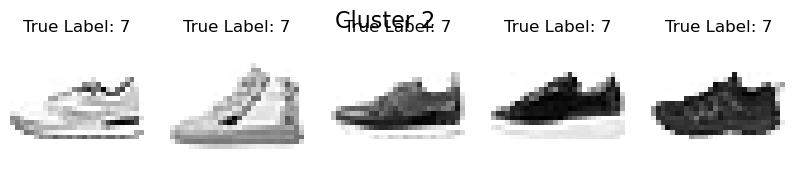

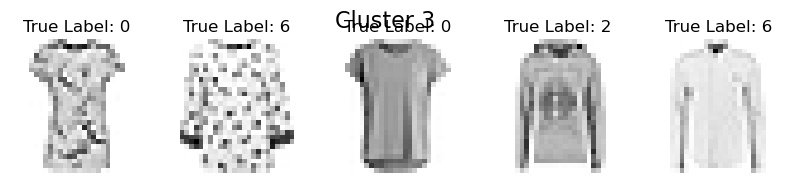

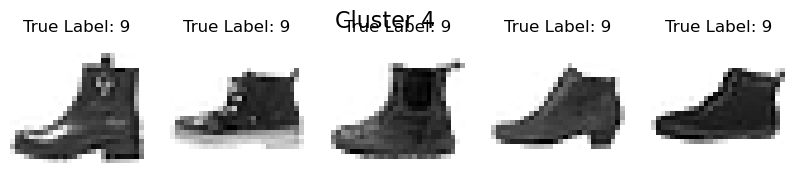

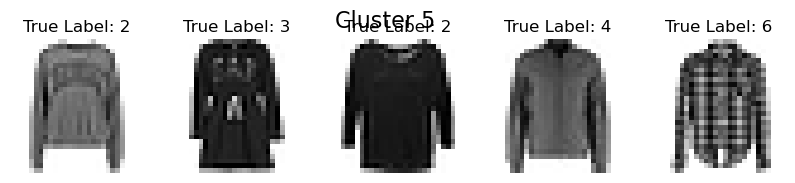

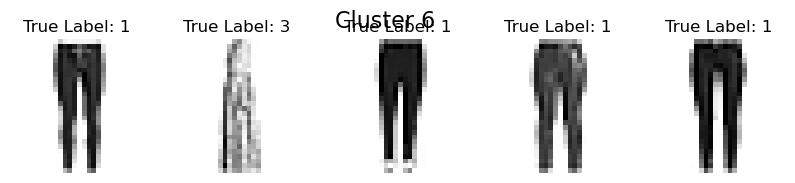

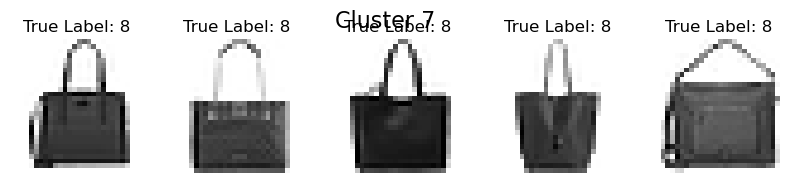

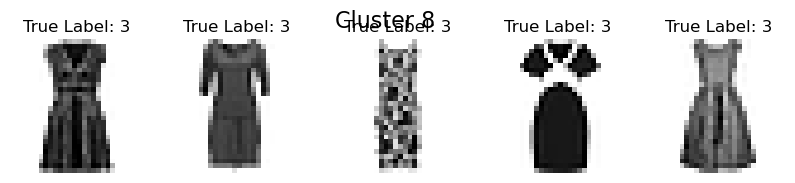

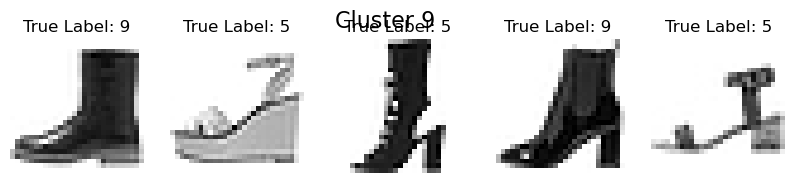

In [18]:
# Function to plot sample images from each cluster
def plot_cluster_samples(data, labels, n_samples_per_cluster=5):
    for i in range(k):
        cluster_indices = np.where(labels == i)[0]
        sample_indices = np.random.choice(cluster_indices, n_samples_per_cluster, replace=False)
        
        plt.figure(figsize=(10, 2))
        plt.suptitle(f'Cluster {i}', fontsize=16)
        for j, idx in enumerate(sample_indices):
            plt.subplot(1, n_samples_per_cluster, j+1)
            plt.imshow(data[idx, :, :, 0], cmap='binary')
            plt.title(f'True Label: {y_all[idx]}')
            plt.axis('off')
        plt.show()

plot_cluster_samples(x_all, cluster_labels)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


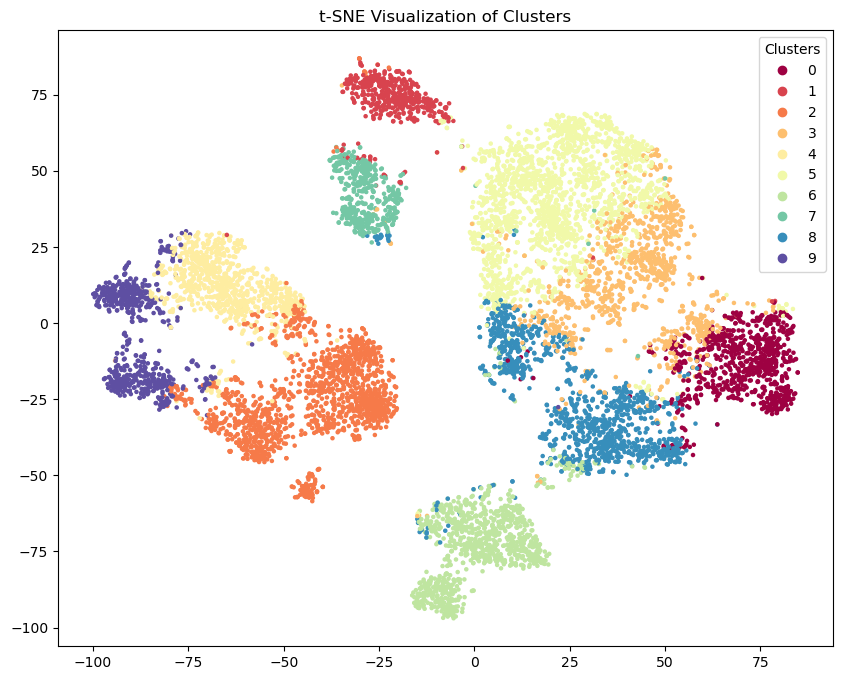

In [19]:
# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=2000)
features_tsne = tsne.fit_transform(features_flat[:10000]) # Using a subset for faster computation

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels[:10000], cmap='Spectral', s=5)
plt.title('t-SNE Visualization of Clusters')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()